In [2]:
import pandas as pd
import warnings

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

path = 'spi_transfers_ver2_ready_for_features.csv'

df = pd.read_csv(path, index_col=0)

warnings.filterwarnings( "ignore", module = "seaborn\..*" )


# Feature Creation

This notebook is dedicated to creating new features for the newly combined `spi` and `transfers` datasets.


### What's happened so far:
 - I started with two datasets, one containing soccer transfers data from nine European leagues over five seasons, and the other containing SPI scores for teams from the same nine leagues over the same five seasons.
 - Both dataframes were cleaned up a bit, but the bulk of the cleaning work was done just before merging the dataframes together. The largest effort in cleaning up the data involved standardizing the team names across the two datasets.
 - I learned something new! I used the FuzzyWuzzy library for the first time, and it is delightful. Using a tutorial, I created a function that matched the team names from each dataframe, and provided the best option for standardizing them for my merged dataframe.


### This notebook will focus on:
 - Feature creation. The dataset I am now working with has massive opportunity for additional features.
 - Next, I'll look at the data more visually, and try to identify some interesting patterns in the data.
 - Finally, I'll work on choosing algorithm(s) for predicting future SPI scores. More on that in another notebook I think...

### STEP ONE: Have a look at the dataset one more time

In [5]:
df.shape

(31080, 14)

In [10]:
df = df[df['fee_millions'] != 0.0]

In [11]:
df.shape

(6880, 14)

This dataframe has 14 columns and 31000+ observations. I will tighten this up a good bit, but I'll still have considerably more datapoints than my previous effort looking at the impact of transfers on soccer team strenght.

In [3]:
%%html
<style>
table {float:left}
</style>

#### Here's a look at the columns that currently exist in this dataset

Column | Definition
----: | :---------
**team_name** | Team name
**player** | Player name
**age** | Age of player
**position** | Player's position
**other_club** | Other team involved in the transfer
**movement** | Whether the player was purchased or sold, e.g. in or out
**window** | There are two transfer windows: summer, winter
**fee_millions** | The fee in millions for the transfer
**league** | Team's home league
**year** | Year associated with each season
**season** | Each season spreads two years, e.g. 2016-2017
**avg_home_spi** | The average SPI score when the team is home
**avg_away_spi** | The average SPI score when the team is away
**avg_spi_score** | The average of home and away SPI scores


In [12]:
# Let's confirm there are no null values
df.isna().sum()

team_name        0
player           0
age              0
position         0
other_club       0
movement         0
window           0
fee_millions     0
league           0
year             0
season           0
avg_home_spi     0
avg_away_spi     0
avg_spi_score    0
dtype: int64

In [13]:
# Renaming team_name to team just to make it easier
df.rename(columns={'team_name': 'team'}, inplace=True)

/home/tdraths/.local/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Positions: Eleven players on a field

There are 11 players on the pitch for each team, but the positions they fill are not limited to 11 different names. Beyond that, some players play a little bit forward when they are backs (see all of Liverpools backline) and some players play a little bit defensively when they are in the midfield. 

There are a lot of formations in soccer. Here are just a small few:
 - 4-4-2 (a classic)
 - 4-3-3 (think West German dominance)
 - 3-6-1 (US '98 World Cup disaster)
 - 4-5-1
 - 1-1-9 (CHARGE!!!!)

Any way you can combine 11 players, you have a formation for soccer. Below, there are 17 distinct positions in the dataframe, which is too many in my opinion. Look closely at the numbers associated with the position counts, and you'll see that the seven positions with the lowest value counts are significantly lower than the other positions listed.

I'm not going to try to assign a `right` or `left` standard to the positions. Instead, I'll take those bottom seven positions and recategorize them.

In [14]:
positions = df.position.unique()
display(df.position.value_counts())
print(positions.shape)

Centre-Forward        1278
Centre-Back           1197
Central Midfield       878
Left Winger            553
Right Winger           550
Defensive Midfield     513
Left-Back              468
Right-Back             446
Attacking Midfield     407
Goalkeeper             395
Second Striker          76
Left Midfield           68
Right Midfield          50
Forward                  1
Name: position, dtype: int64

(14,)


How I'll rename the positions:
 - I'm going to rename centre-forward, second striker and forward as `striker`. Centre-forward has the highest value count, but I like striker as a more all-encompassing description of an attack-only player.
 - I'm renaming left midfield as `left winger` and right midfield as `right winger`.
 - I'm renaming midfielder and midfield as `central midfield`, and defender as `defensive midfield`. 

In [15]:
new_position = {'Centre-Forward': 'Striker',
                'Second Striker': 'Striker',
                'Left Midfield': 'Left Winger',
                'Right Midfield': 'Right Winger',
                'Forward': 'Striker',
                'Midfielder': 'Central Midfield',
                'Defender': 'Defensive Midfield',
                'midfield': 'Central Midfield'}

df.position.replace(new_position, inplace=True)
df.position.value_counts()

/home/tdraths/.local/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Striker               1355
Centre-Back           1197
Central Midfield       878
Left Winger            621
Right Winger           600
Defensive Midfield     513
Left-Back              468
Right-Back             446
Attacking Midfield     407
Goalkeeper             395
Name: position, dtype: int64

### STEP TWO: Build new features for the dataframe

It's time! New features await!

Here's the list of new features that I'll create:

New Feature | Definition
----: | :---------
**total_transfers_in** | Sum of transfers purchased (in) by a team
**total_transfers_out** | Sum of transfers sold (out) by a team
**total_spend** | Sum of the amount spent on purchases (in) by a team
**total_earned** | Sum of the amount earned on sales (out) by a team
**average_fee_spend** | Average fee spent on a purchase (in) by a team
**average_fee_earned** | Average fee earned on a sale (out) by a team
**max_fee_spend** | Max fee spent on a purchase (in) in a season
**min_fee_spend** | Min fee spent on a purchase (in) in a season
**avg_home_spi** | Average home spi score for a team
**avg_away_spi** | Average away spi score for a team
**avg_season_spi** | Average spi score for a team across an entire season
**most_purchased_position** | Position with the most purchases for a team
**position_max_spend** | Position with the highest amount spent (in) by a team
**position_min_spend** | Position with the least amount spent (in) by a team
**avg_spend_striker** | Average spent on a goalkeeper
**avg_spend_centre_back** | Average spent on a goalkeeper
**avg_spend_centre_mid** | Average spent on a goalkeeper
**avg_spend_goalkeeper** | Average spent on a goalkeeper
**avg_spend_left_winger** | Average spent on a goalkeeper
**avg_spend_right_winger** | Average spent on a goalkeeper
**avg_spend_def_midfield** | Average spent on a goalkeeper
**avg_spend_left_back** | Average spent on a goalkeeper
**avg_spend_right_back** | Average spent on a goalkeeper
**avg_spend_att_midfield** | Average spent on a goalkeeper


#### First, I'll define a function to get the most frequent position for a team in a given season


In [16]:
def get_most_frequent(column):
    if len(column) > 0:
        return column.value_counts().index[0]
    else:
        return -1

#### Second, I'll create a function to groupby and aggregate for feature creation

In [17]:
def my_agg(x):
    features = {
        'total_transfers_in': x[x['movement'] == 'in']['fee_millions'].count(),
        'total_transfer_out': x[x['movement'] == 'out']['fee_millions'].count(),
        'total_spend': x[x['movement'] == 'in']['fee_millions'].sum(),
        'total_earned': x[x['movement'] == 'out']['fee_millions'].sum(),
        'average_fee_spend': x[x['movement'] == 'in']['fee_millions'].mean(),
        'average_fee_earned': x[x['movement'] == 'out']['fee_millions'].mean(),
        'max_fee_spend': x[x['movement'] == 'in']['fee_millions'].max(),
        'min_fee_spend': x[x['movement'] == 'out']['fee_millions'].max(),
        'avg_home_spi': x['avg_home_spi'].mean(),
        'avg_away_spi': x['avg_away_spi'].mean(),
        'avg_season_spi': x['avg_spi_score'].mean(),
        'most_purchased_position': get_most_frequent(x[x['movement'] == 'in']['position']),
        'position_max_spend': x.sort_values(by='fee_millions', ascending=False)['position'].iloc[0],
        'position_min_spend': x.sort_values(by='fee_millions', ascending=True)['position'].iloc[0],
        'avg_spend_striker': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Striker')]['fee_millions'].mean(),
        'avg_spend_centre_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Centre-Back')]['fee_millions'].mean(),
        'avg_spend_centre_mid': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Central Midfield')]['fee_millions'].mean(),
        'avg_spend_goalkeeper': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Goalkeeper')]['fee_millions'].mean(),
        'avg_spend_left_winger': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Left Winger')]['fee_millions'].mean(),
        'avg_spend_right_winger': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Right Winger')]['fee_millions'].mean(),
        'avg_spend_def_midfield': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Defensive Midfield')]['fee_millions'].mean(),
        'avg_spend_left_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Left-Back')]['fee_millions'].mean(),
        'avg_spend_right_back': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Right-Back')]['fee_millions'].mean(),
        'avg_spend_att_midfield': x[(x['movement'] == 'in') &
                                         (x['position'] == 'Attacking Midfield')]['fee_millions'].mean()
    }
    
    return pd.Series(features)

#### Third, I apply the aggregation to `df` grouped by `year`, `team` and `league`. 


In [18]:
df = df.groupby(['year', 'team', 'league'], as_index=False).apply(my_agg)
df.sort_values(by=['team', 'year'], inplace=True)
df.sort_index(inplace=True)

In [19]:
# A quick look at the new df
df.head()

year             team                  league  total_transfers_in  \
0  2016   1.FSV Mainz 05       German Bundesliga                  10   
1  2016         AC Milan         Italian Serie A                   7   
2  2016   ACF Fiorentina         Italian Serie A                  10   
3  2016  AFC Bournemouth  English Premier League                   7   
4  2016        AS Monaco          French Ligue 1                   5   

   total_transfer_out  total_spend  total_earned  average_fee_spend  \
0                   5       26.284        23.135           2.628400   
1                   7       26.600        22.640           3.800000   
2                  10       14.157        27.950           1.415700   
3                   6       36.626        21.321           5.232286   
4                   6       45.450        16.605           9.090000   

   average_fee_earned  max_fee_spend  ...  avg_spend_striker  \
0            4.627000           5.85  ...               4.05   
1            3.234286           8.60  ...               8.55   
2            2.795000           3.15  ...                NaN   
3            3.553500          16.20  ...               5.85   
4            2.767500          13.50  ...                NaN   

   avg_spend_centre_back  avg_spend_centre_mid  avg_spend_goalkeeper  \
0                  0.450                 1.930                2.2500   
1                  8.600                 3.825                   NaN   
2                  2.025                 0.450                1.2735   
3                  2.070                 4.210                0.8460   
4                  9.900                 2.700                   NaN   

  avg_spend_left_winger avg_spend_right_winger avg_spend_def_midfield  \
0                  2.70                   3.15                    4.5   
1                  0.63                   0.45                    NaN   
2                  0.45                    NaN                    NaN   
3                   NaN                  16.20                    NaN   
4                   NaN                    NaN                    NaN   

   avg_spend_left_back  avg_spend_right_back  avg_spend_att_midfield  
0                0.054                   NaN                     NaN  
1                  NaN                   NaN                   0.720  
2                0.900                  2.61                   1.575  
3                3.240                   NaN                     NaN  
4                9.675                 13.50                     NaN  

[5 rows x 27 columns]

##### `avg_home_spi` and `avg_away_spi` need to be dropped, because they helped created `avg_season_spi`

In [20]:
df.drop(columns=['avg_home_spi', 'avg_away_spi'], inplace=True)

In [21]:
display(df.shape)
df.isna().sum()

(742, 25)

year                         0
team                         0
league                       0
total_transfers_in           0
total_transfer_out           0
total_spend                  0
total_earned                 0
average_fee_spend           52
average_fee_earned          59
max_fee_spend               52
min_fee_spend               59
avg_season_spi               0
most_purchased_position      0
position_max_spend           0
position_min_spend           0
avg_spend_striker          273
avg_spend_centre_back      323
avg_spend_centre_mid       400
avg_spend_goalkeeper       535
avg_spend_left_winger      465
avg_spend_right_winger     473
avg_spend_def_midfield     511
avg_spend_left_back        518
avg_spend_right_back       527
avg_spend_att_midfield     558
dtype: int64

#### WOW!

If I'm honest, I find that process pretty fun. It took some Google searching to find the right aggs for my features, but I'm better for it and I'm really excited to crack on with the next steps.

What just happend:
 - I created a heap of new features to get better info around which positions matter to teams, and then I grouped the dataframe by year and team. This cut my datapoints down to 700+ from 31000+, but I now have a datapoint for each team, for each season, and a whole lot of other fun data alongside that wasn't 'visible' before.

First, I'll fill the new null values with zeroes. If they are missing, it's because the position didn't exist in a team's purchases that season.

In [22]:
df.fillna(0,inplace=True)
df.dtypes

year                         int64
team                        object
league                      object
total_transfers_in           int64
total_transfer_out           int64
total_spend                float64
total_earned               float64
average_fee_spend          float64
average_fee_earned         float64
max_fee_spend              float64
min_fee_spend              float64
avg_season_spi             float64
most_purchased_position     object
position_max_spend          object
position_min_spend          object
avg_spend_striker          float64
avg_spend_centre_back      float64
avg_spend_centre_mid       float64
avg_spend_goalkeeper       float64
avg_spend_left_winger      float64
avg_spend_right_winger     float64
avg_spend_def_midfield     float64
avg_spend_left_back        float64
avg_spend_right_back       float64
avg_spend_att_midfield     float64
dtype: object

### STEP THREE: Visualize that data!

To have a look at patterns in the new dataframe, I'm going to use the `QuickDA` library. I've never used it before, so I'll give it my best shot and crack on from there.

QuickDA has a number of functions and parameters that are supposed to make EDA a faster, easier, less painful process. I'm going to give it a bash, and if I need to use other visualizations to find patterns, I will.

#### First, the `explore` method summarizes the dataset like `.describe()`, but includes columns of any data type.

In [23]:
explore(df, method='summarize')

dtypes  count  null_sum  null_pct  nunique  \
average_fee_earned       float64    742         0       0.0      576   
average_fee_spend        float64    742         0       0.0      620   
avg_season_spi           float64    742         0       0.0      716   
avg_spend_att_midfield   float64    742         0       0.0      103   
avg_spend_centre_back    float64    742         0       0.0      226   
avg_spend_centre_mid     float64    742         0       0.0      192   
avg_spend_def_midfield   float64    742         0       0.0      116   
avg_spend_goalkeeper     float64    742         0       0.0      101   
avg_spend_left_back      float64    742         0       0.0      122   
avg_spend_left_winger    float64    742         0       0.0      140   
avg_spend_right_back     float64    742         0       0.0      111   
avg_spend_right_winger   float64    742         0       0.0      132   
avg_spend_striker        float64    742         0       0.0      260   
league                    object    742         0       0.0        9   
max_fee_spend            float64    742         0       0.0      236   
min_fee_spend            float64    742         0       0.0      252   
most_purchased_position   object    742         0       0.0       11   
position_max_spend        object    742         0       0.0       10   
position_min_spend        object    742         0       0.0       10   
team                      object    742         0       0.0      214   
total_earned             float64    742         0       0.0      570   
total_spend              float64    742         0       0.0      591   
total_transfer_out         int64    742         0       0.0       20   
total_transfers_in         int64    742         0       0.0       19   
year                       int64    742         0       0.0        5   

                                        min      25%       50%       75%  \
average_fee_earned                      0.0     1.35       3.6  7.425562   
average_fee_spend                       0.0     0.99   2.79385     6.975   
avg_season_spi                        24.42  49.3575    60.935    70.995   
avg_spend_att_midfield                  0.0      0.0       0.0       0.0   
avg_spend_centre_back                   0.0      0.0  0.528833  3.150937   
avg_spend_centre_mid                    0.0      0.0       0.0  2.840625   
avg_spend_def_midfield                  0.0      0.0       0.0      0.72   
avg_spend_goalkeeper                    0.0      0.0       0.0     0.315   
avg_spend_left_back                     0.0      0.0       0.0      0.45   
avg_spend_left_winger                   0.0      0.0       0.0       1.8   
avg_spend_right_back                    0.0      0.0       0.0      0.63   
avg_spend_right_winger                  0.0      0.0       0.0     1.505   
avg_spend_striker                       0.0      0.0      1.13      5.03   
league                     Dutch Eredivisie        -         -         -   
max_fee_spend                           0.0      1.8      5.85      15.3   
min_fee_spend                           0.0     2.25       8.1      19.8   
most_purchased_position                   -        -         -         -   
position_max_spend       Attacking Midfield        -         -         -   
position_min_spend       Attacking Midfield        -         -         -   
team                         1.FC Nuremberg        -         -         -   
total_earned                            0.0    2.745    14.074  38.98125   
total_spend                             0.0   3.1965   14.2945    44.865   
total_transfer_out                        0      2.0       3.0       6.0   
total_transfers_in                        0      3.0       5.0       7.0   
year                                   2016   2017.0    2018.0    2019.0   

                                          max         mean    median  \
average_fee_earned                       72.0     5.580295       3.6   
average_fee_spend               

#### Second, QuickDA has a `clean()` function that can remove duplicates, null values, change data types, etc.

In [24]:
df = clean(df, method='duplicates')

In [25]:
to_categoric = ['most_purchased_position', 'position_max_spend', 'position_min_spend']
df = clean(df, method='dtypes', columns=to_categoric, dtype='category')

#### Third, QuickDA has a `eda_num()` function that visualizes creates a boxplot and a distribution plot of each numerical feature.

Outlier Analysis - Boxplot


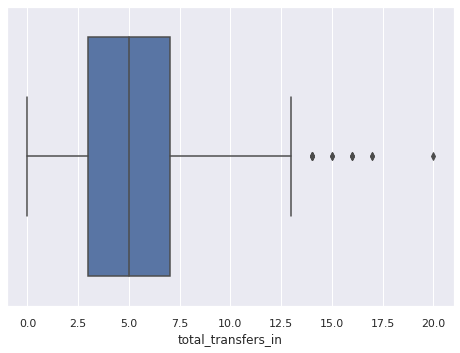

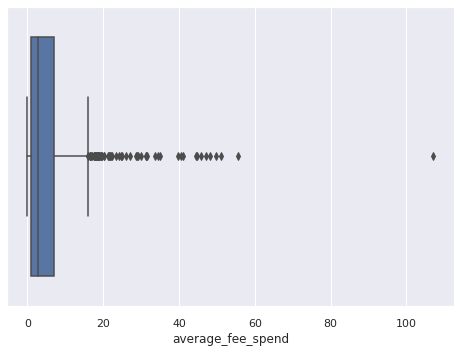

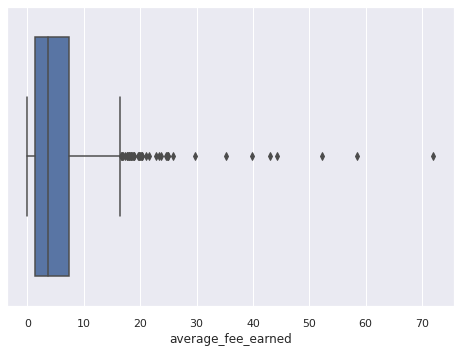

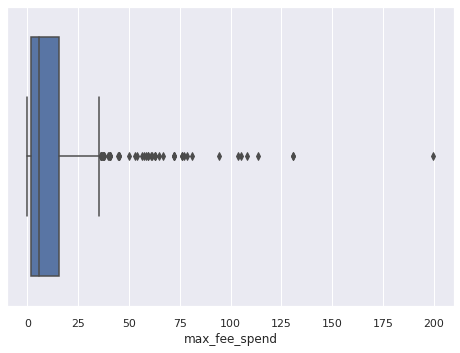

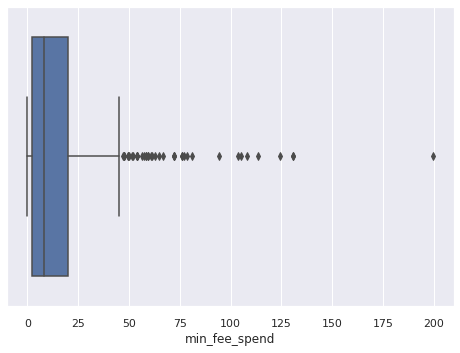

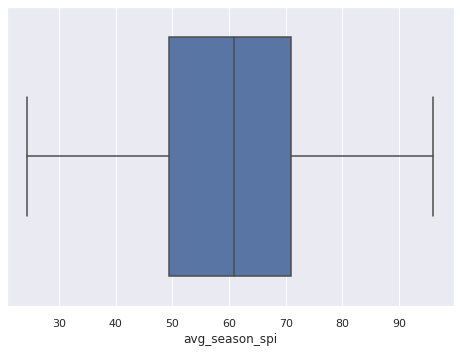

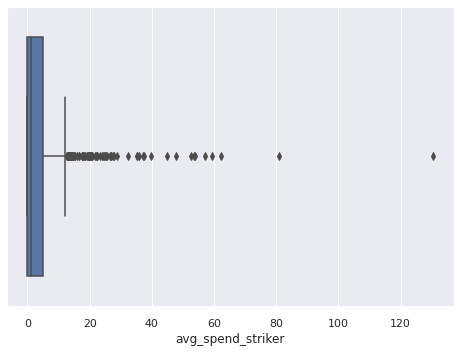

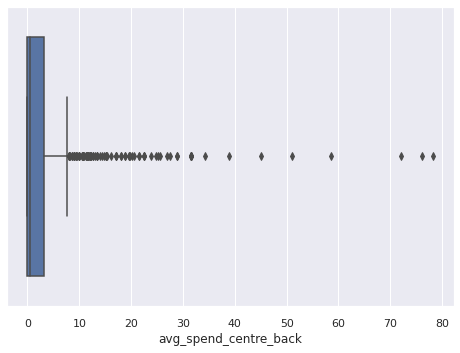

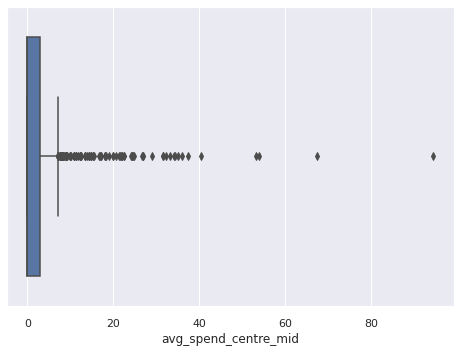

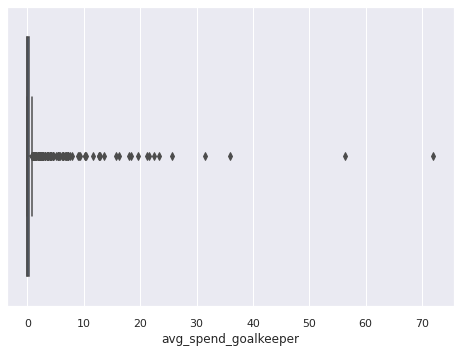

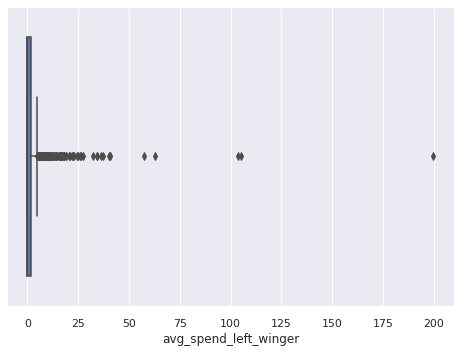

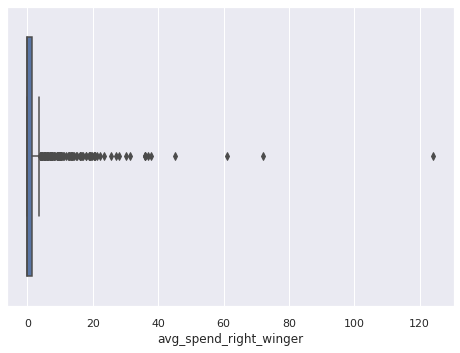

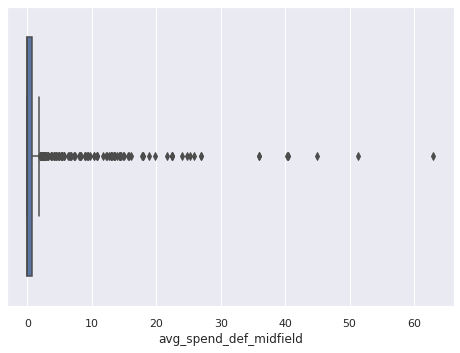

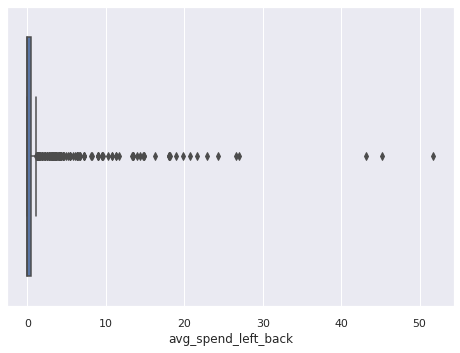

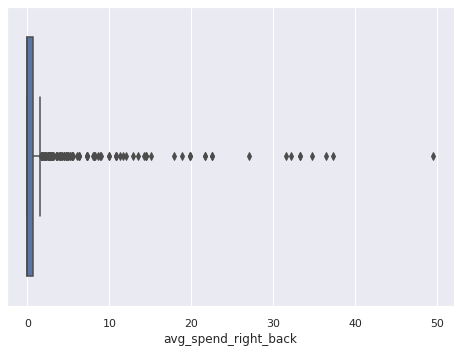

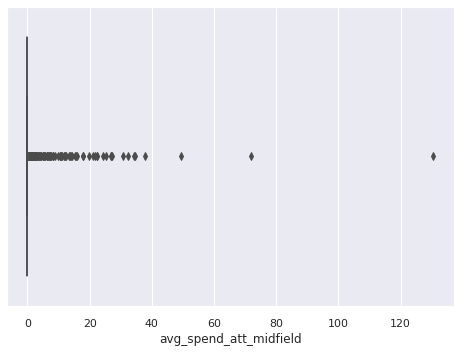

Distribution Analysis - Histogram


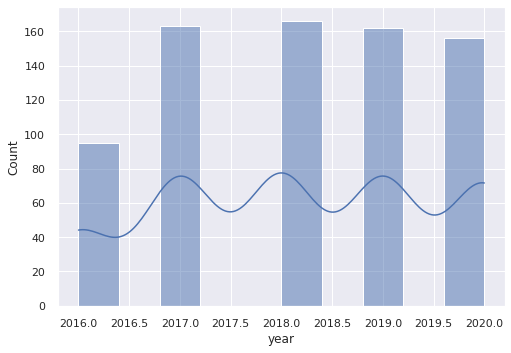

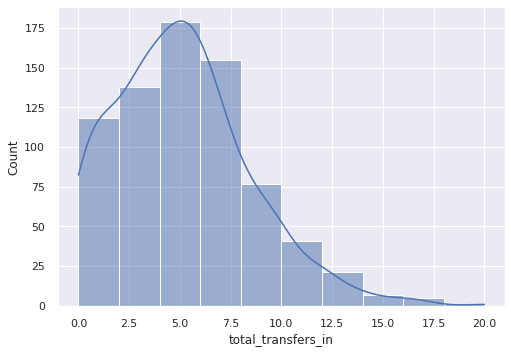

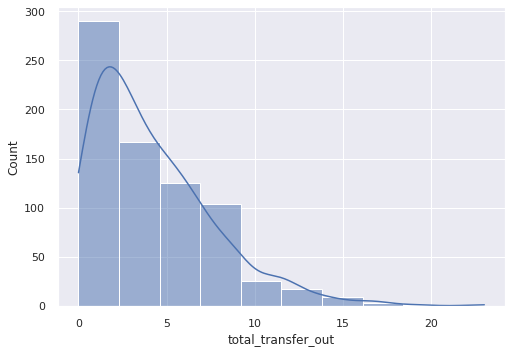

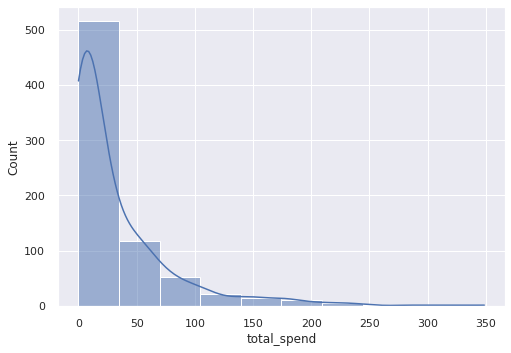

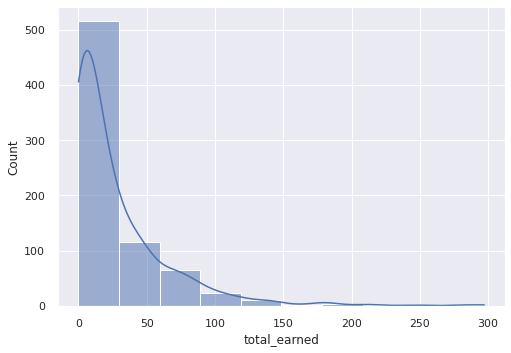

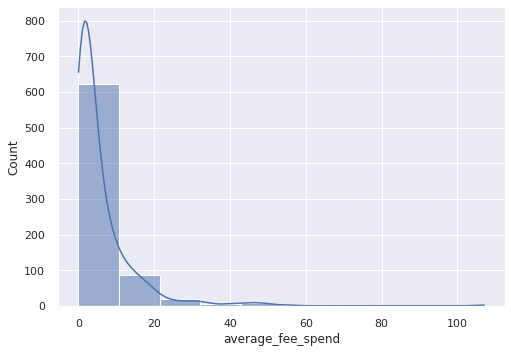

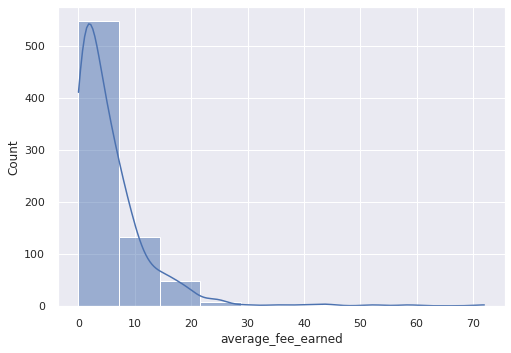

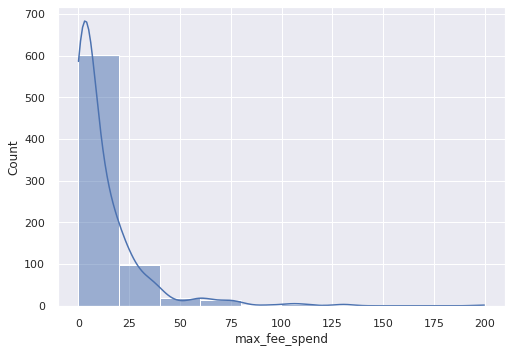

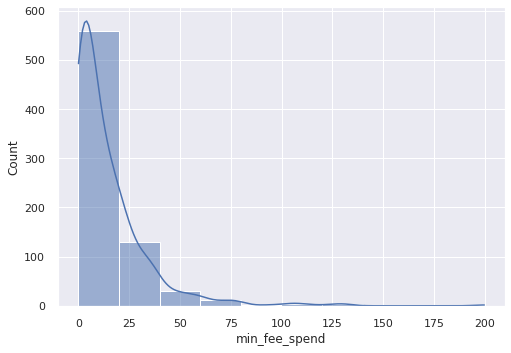

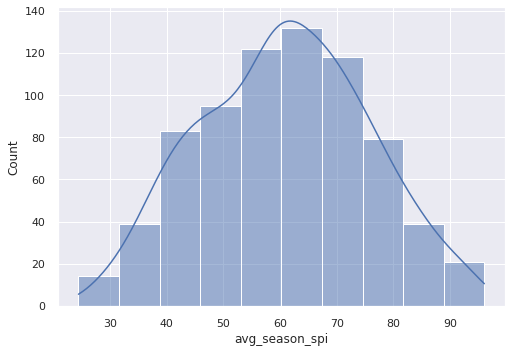

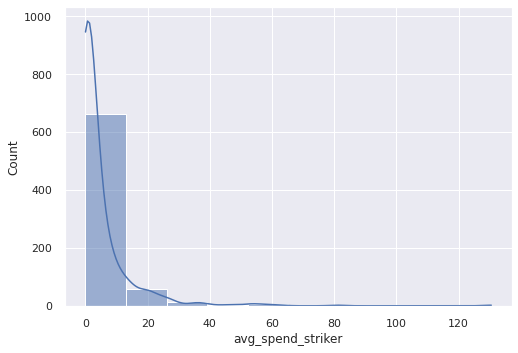

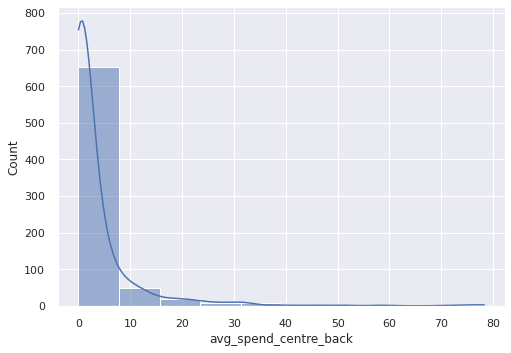

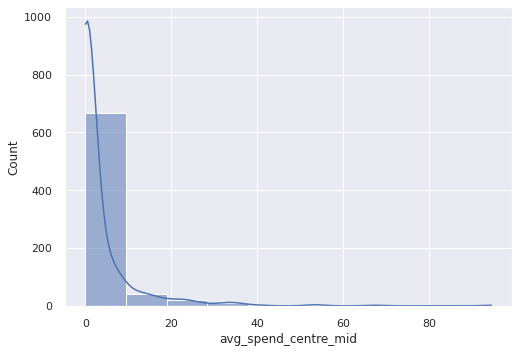

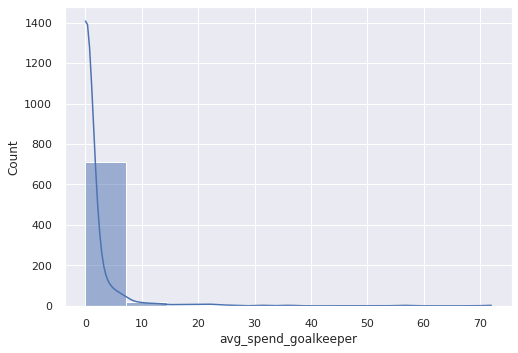

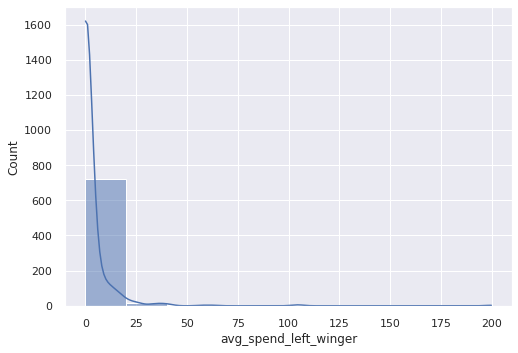

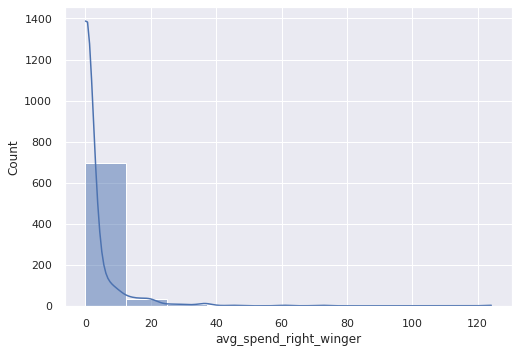

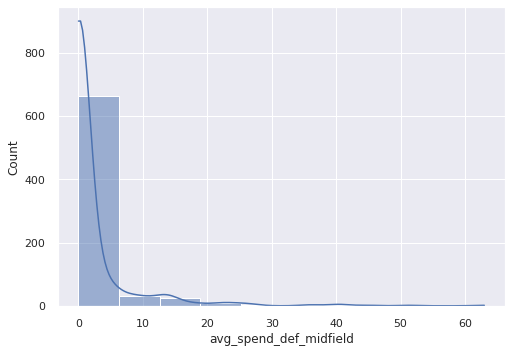

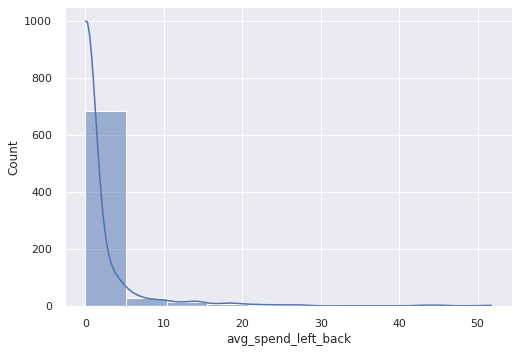

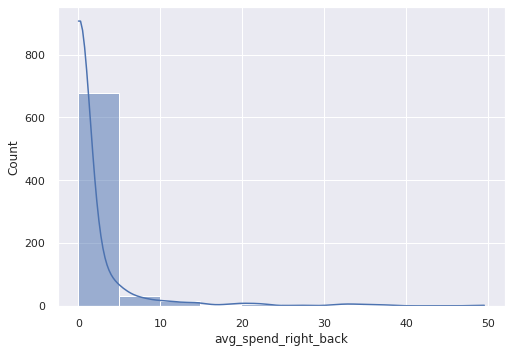

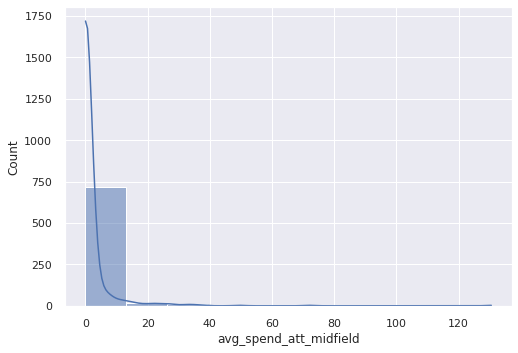

In [26]:
eda_num(df, method='default', bins=10)

#### Fourth, QuickDA has a function `eda_cat()` that creates a barplot and a summary of each categorical feature.

Bar Plot of most_purchased_position


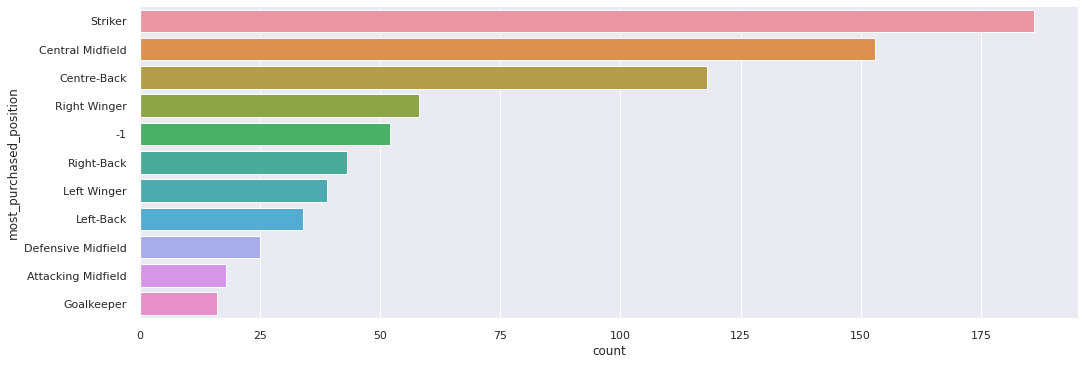

Summary of most_purchased_position


count  relative_pct
Striker               186          0.25
Central Midfield      153          0.21
Centre-Back           118          0.16
Right Winger           58          0.08
-1                     52          0.07
Right-Back             43          0.06
Left Winger            39          0.05
Left-Back              34          0.05
Defensive Midfield     25          0.03
Attacking Midfield     18          0.02
Goalkeeper             16          0.02

In [27]:
eda_cat(df, 'most_purchased_position')

Bar Plot of position_max_spend


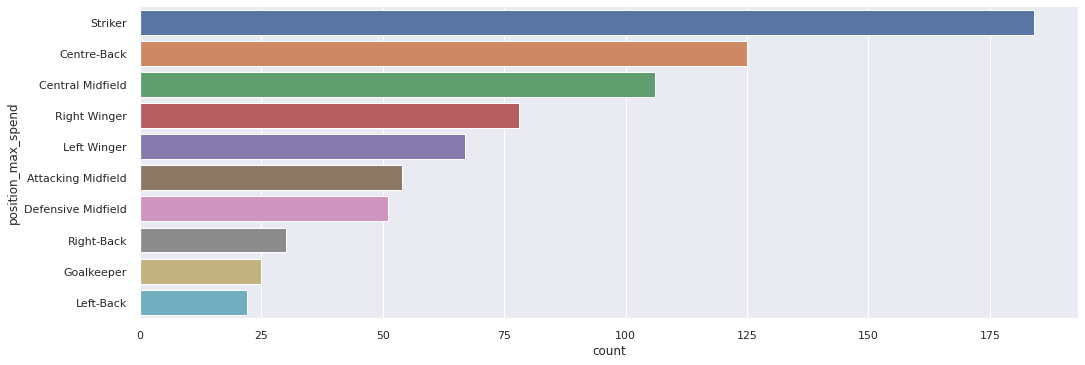

Summary of position_max_spend


count  relative_pct
Striker               184          0.25
Centre-Back           125          0.17
Central Midfield      106          0.14
Right Winger           78          0.11
Left Winger            67          0.09
Attacking Midfield     54          0.07
Defensive Midfield     51          0.07
Right-Back             30          0.04
Goalkeeper             25          0.03
Left-Back              22          0.03

In [28]:
eda_cat(df, 'position_max_spend')

Bar Plot of position_min_spend


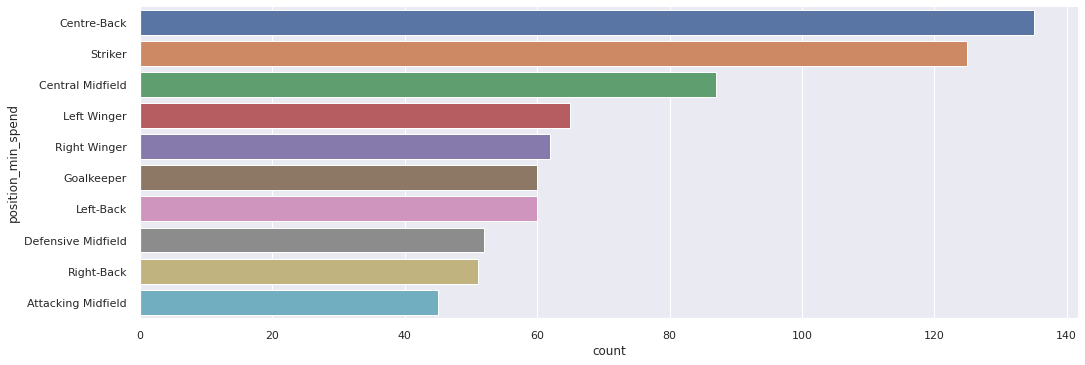

Summary of position_min_spend


count  relative_pct
Centre-Back           135          0.18
Striker               125          0.17
Central Midfield       87          0.12
Left Winger            65          0.09
Right Winger           62          0.08
Goalkeeper             60          0.08
Left-Back              60          0.08
Defensive Midfield     52          0.07
Right-Back             51          0.07
Attacking Midfield     45          0.06

In [29]:
eda_cat(df, 'position_min_spend')

In [30]:
# Creating a list of the numerical and categorical features
numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical = df.select_dtypes(include=['category']).columns.tolist()

### QuickDA Review and Next Steps:

QuickDA uses a few functions with a variety of parameter options to create visualizations and summaries of a dataframe's features. It's a good library, and it has a wider range of chart features that I didn't utilize here.

However, I think coming up with your own methods for visualizing data and creating functions to help you in this step are as useful as QuickDA. In the future, I think I'd use QuickDA to be...quick. And use my own functions or methods to be more deliberate in my analysis.

And to that point - I'll continue with my own functions and methods.

In [31]:
def plot_categorical(df, var_name, target_name, width=7, height=5):
    '''
    Takes a categorical variable and provides a summary 
    and a visualization of that variable as it relates 
    to the target variable.
    
    df = dataframe
    var_name = categorical feature
    target_name = target feature
    '''
    ratio_population = round(df.loc[:, target_name].mean(), 1)
    target_proportion = round(df.loc[:, [target_name, var_name]].groupby([var_name]).mean(), 1)
    print(target_proportion)
    
    categorical_distribution = df.loc[:, [target_name, var_name]].groupby([var_name]).count()
    
    fig = plt.figure(figsize=(width, height))
    fig.autofmt_xdate(rotation=45)
    ax = categorical_distribution[target_name].plot(kind='bar')
    ax.set_ylabel('Number of Samples', color='black')
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.plot(target_proportion[target_name].values, color='darkorange', linestyle='-', 
             alpha=0.9, marker='.', markeredgewidth=2, linewidth=3.0)
    ax2.set_ylabel('Average Season SPI')
    plt.title('Description of Variable: {0}\n Average Season SPI: {1}'.format(
        var_name, ratio_population));
    
def plot_continuous(df, var_name, target_name, width=7, height=5, bins='auto'):
    '''
    Takes a continuous variable and provides a summary 
    and a visualization of that variable as it relates 
    to the target variable.
    
    df = dataframe
    var_name = continuous feature
    target_name = target feature
    '''
    plot_categorical(df, var_name, target_name, width=7, height=5);

                         avg_season_spi
most_purchased_position                
-1                                 45.6
Attacking Midfield                 55.0
Central Midfield                   63.0
Centre-Back                        64.7
Defensive Midfield                 61.4
Goalkeeper                         56.0
Left Winger                        62.9
Left-Back                          62.8
Right Winger                       60.0
Right-Back                         66.8
Striker                            59.9
                    avg_season_spi
position_max_spend                
Attacking Midfield            59.3
Central Midfield              61.6
Centre-Back                   61.7
Defensive Midfield            61.3
Goalkeeper                    56.3
Left Winger                   65.2
Left-Back                     56.2
Right Winger                  61.2
Right-Back                    59.1
Striker                       59.9
                    avg_season_spi
position_min_spend       

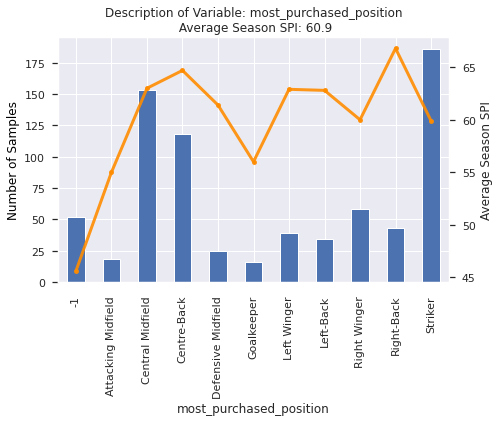

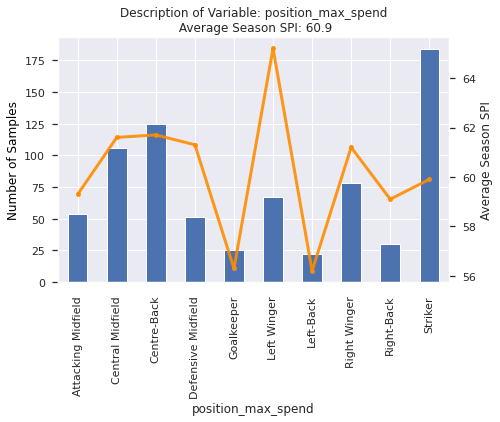

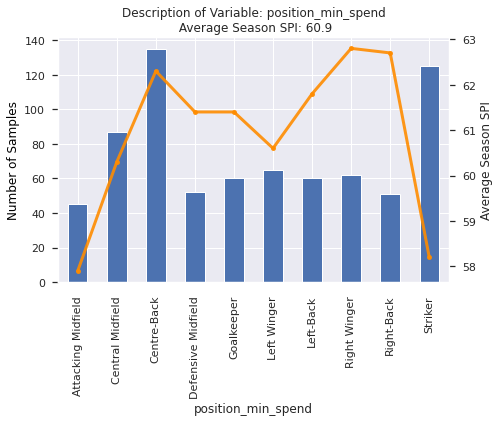

In [32]:
for var in categorical:
    plot_categorical(df, var, 'avg_season_spi')

#### I like to create violin plots to help me understand distributions more clearly. QuickDA does this, but they aren't hard to do quickly on your own if you're keen.

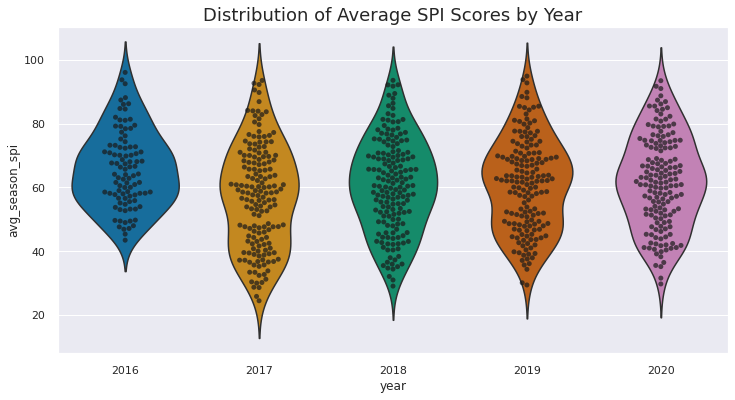

In [33]:
plt.figure(figsize=(12,6))
sns.violinplot(x='year',
              y='avg_season_spi',
              data=df,
              inner=None,
              palette= 'colorblind')

sns.swarmplot(x='year',
              y='avg_season_spi',
              data=df,
              color='k',
              alpha=0.7)

plt.title('Distribution of Average SPI Scores by Year', fontsize=18);

#### A quick look at the ten best and ten worst teams in terms of `avg_season_spi`

In [34]:
display(df.sort_values(by='avg_season_spi', ascending=False)[['team', 'avg_season_spi']].head(10))
display(df.sort_values(by='avg_season_spi')[['team', 'avg_season_spi']].head(10))

team  avg_season_spi
31      FC Barcelona           96.04
514  Manchester City           94.88
443    Bayern Munich           93.77
12     Bayern Munich           93.72
351  Manchester City           93.56
151     FC Barcelona           93.52
673  Manchester City           93.44
511     Liverpool FC           92.75
116    Bayern Munich           92.64
63       Real Madrid           92.49

team  avg_season_spi
214  Roda JC Kerkrade           24.42
129     Burton Albion           25.79
122  Bolton Wanderers           28.56
194         NAC Breda           28.67
357         NAC Breda           29.02
536      RKC Waalwijk           29.37
730         VVV-Venlo           29.69
114       Barnsley FC           29.96
572         VVV-Venlo           30.06
119   Birmingham City           30.15

#### This isn't the prettiest boxplot ever, but it does a good job showing the range of `avg_season_spi` scores by season for each club in the dataset.

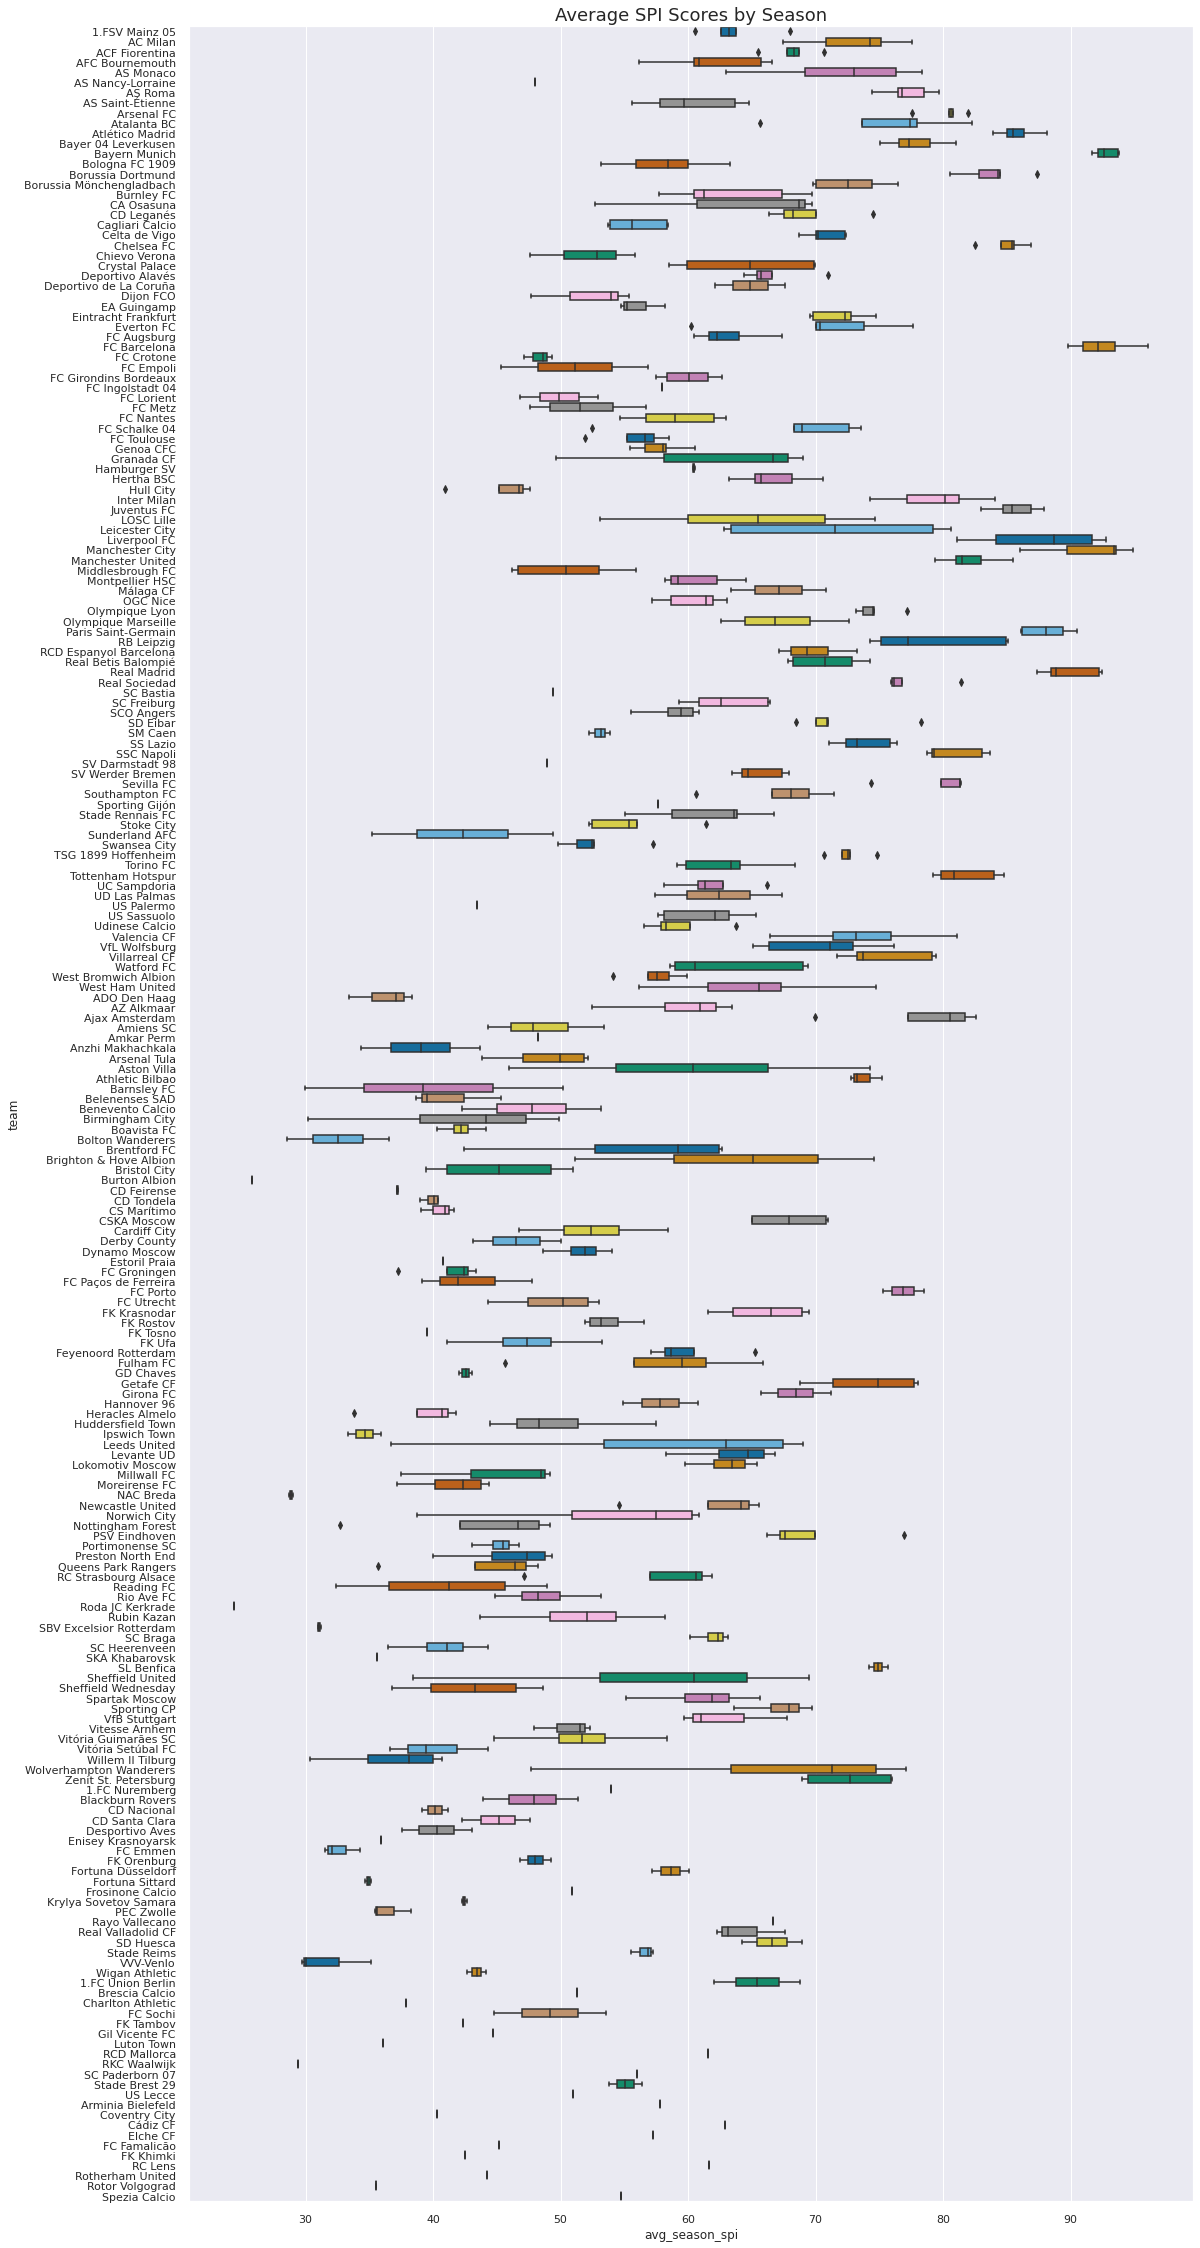

In [35]:
plt.figure(figsize=(18,40))
sns.boxplot(x='avg_season_spi', y='team', data=df, palette='colorblind')
plt.title('Average SPI Scores by Season', fontsize=18);

#### Again, not the prettiest, but another boxplot that shows the `average_fee_spend` by team by season.

Have a look at Inter Milan's spread, and at how much of the dataset tend to spend basically the same amount each season.

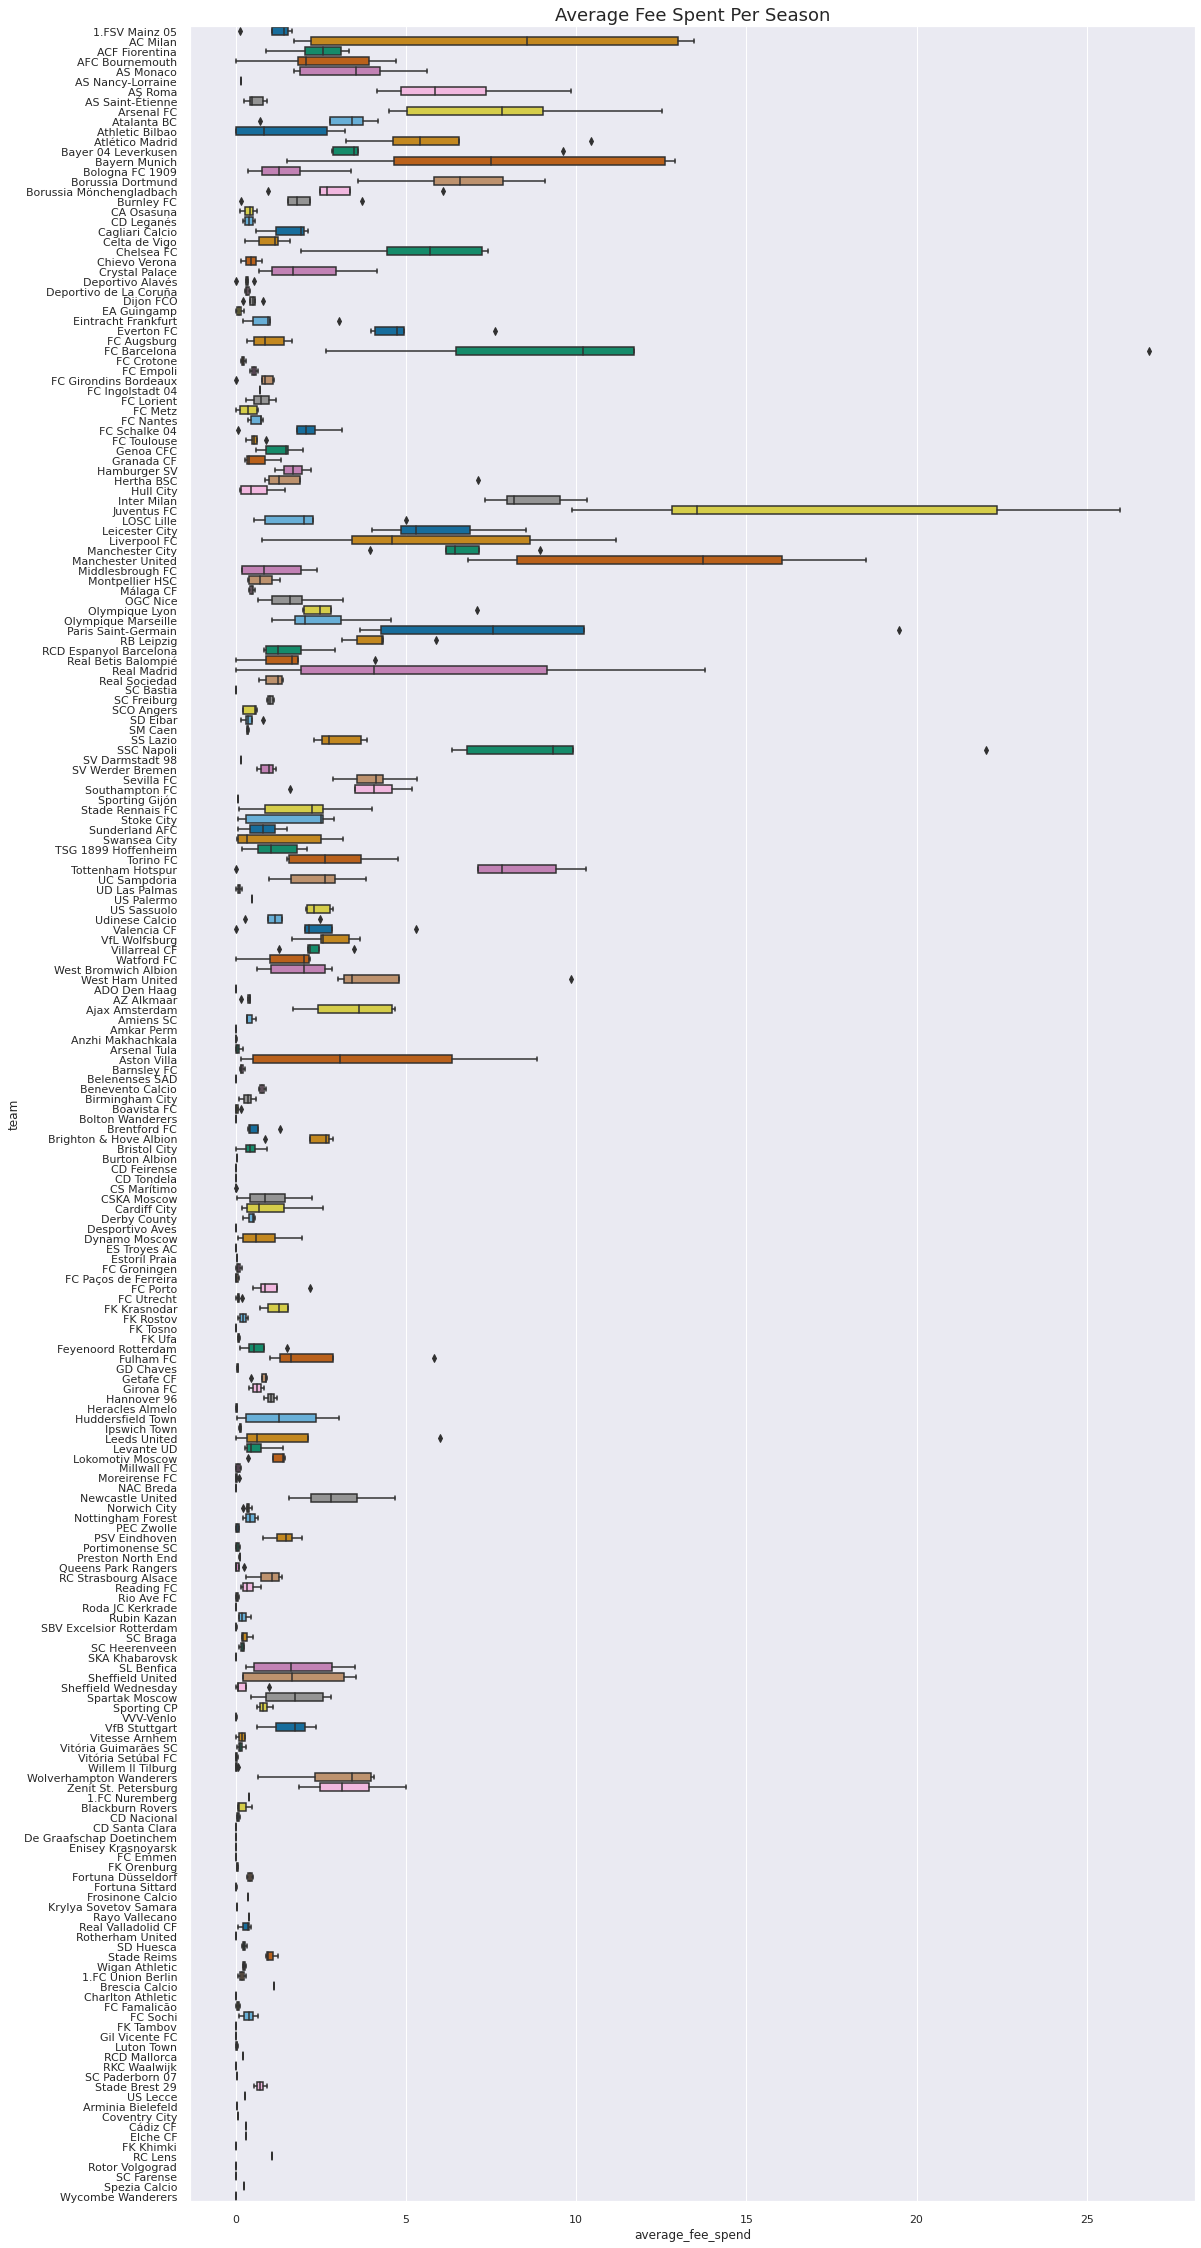

In [28]:
plt.figure(figsize=(18,40))
sns.boxplot(x='average_fee_spend', y='team', data=df, palette='colorblind')
plt.title('Average Fee Spent Per Season', fontsize=18);

#### I love swarmplots as well. I don't know why; I just think they show distributions really well, generally.
For instance, the plot below doesn't tell us much about each league, or each team. It just shows the `average_fee_spend` by year. There's at least one outlier per season, and from the boxplots above, I can get an idea of which teams might make up the outliers.

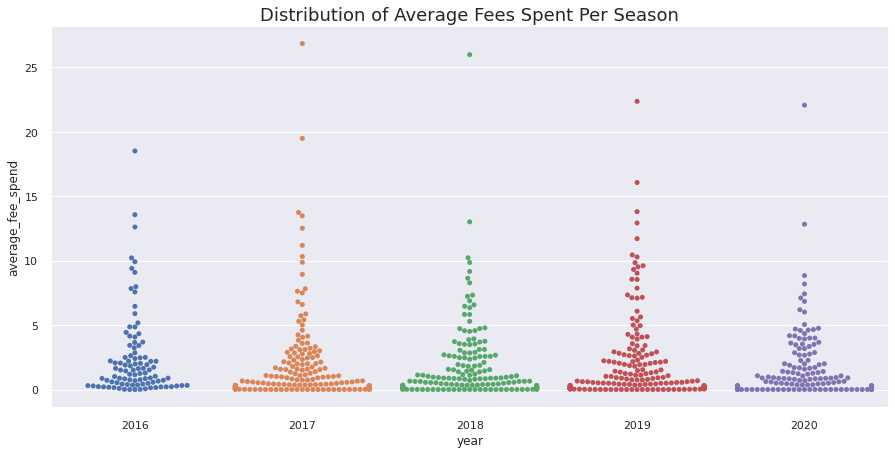

In [29]:
plt.figure(figsize=(15,7))
sns.swarmplot(x='year', y='average_fee_spend', data=df)
plt.title('Distribution of Average Fees Spent Per Season', fontsize=18);

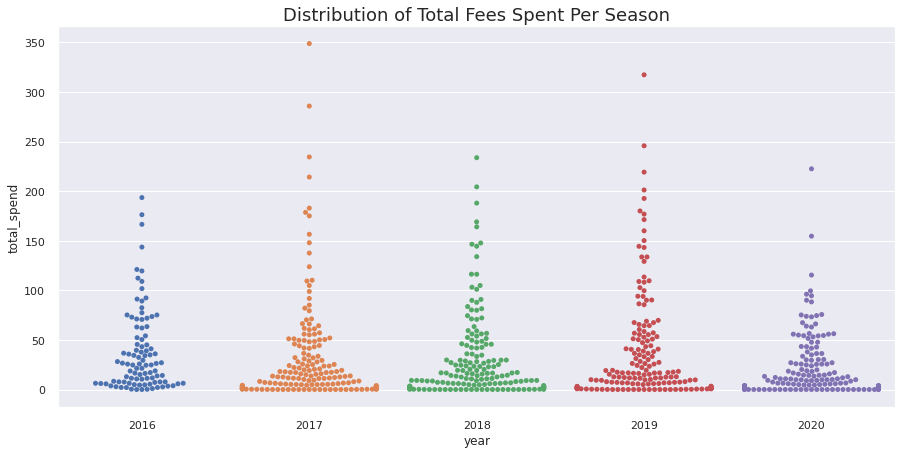

In [30]:
plt.figure(figsize=(15,7))
sns.swarmplot(x='year', y='total_spend', data=df)
plt.title('Distribution of Total Fees Spent Per Season', fontsize=18);

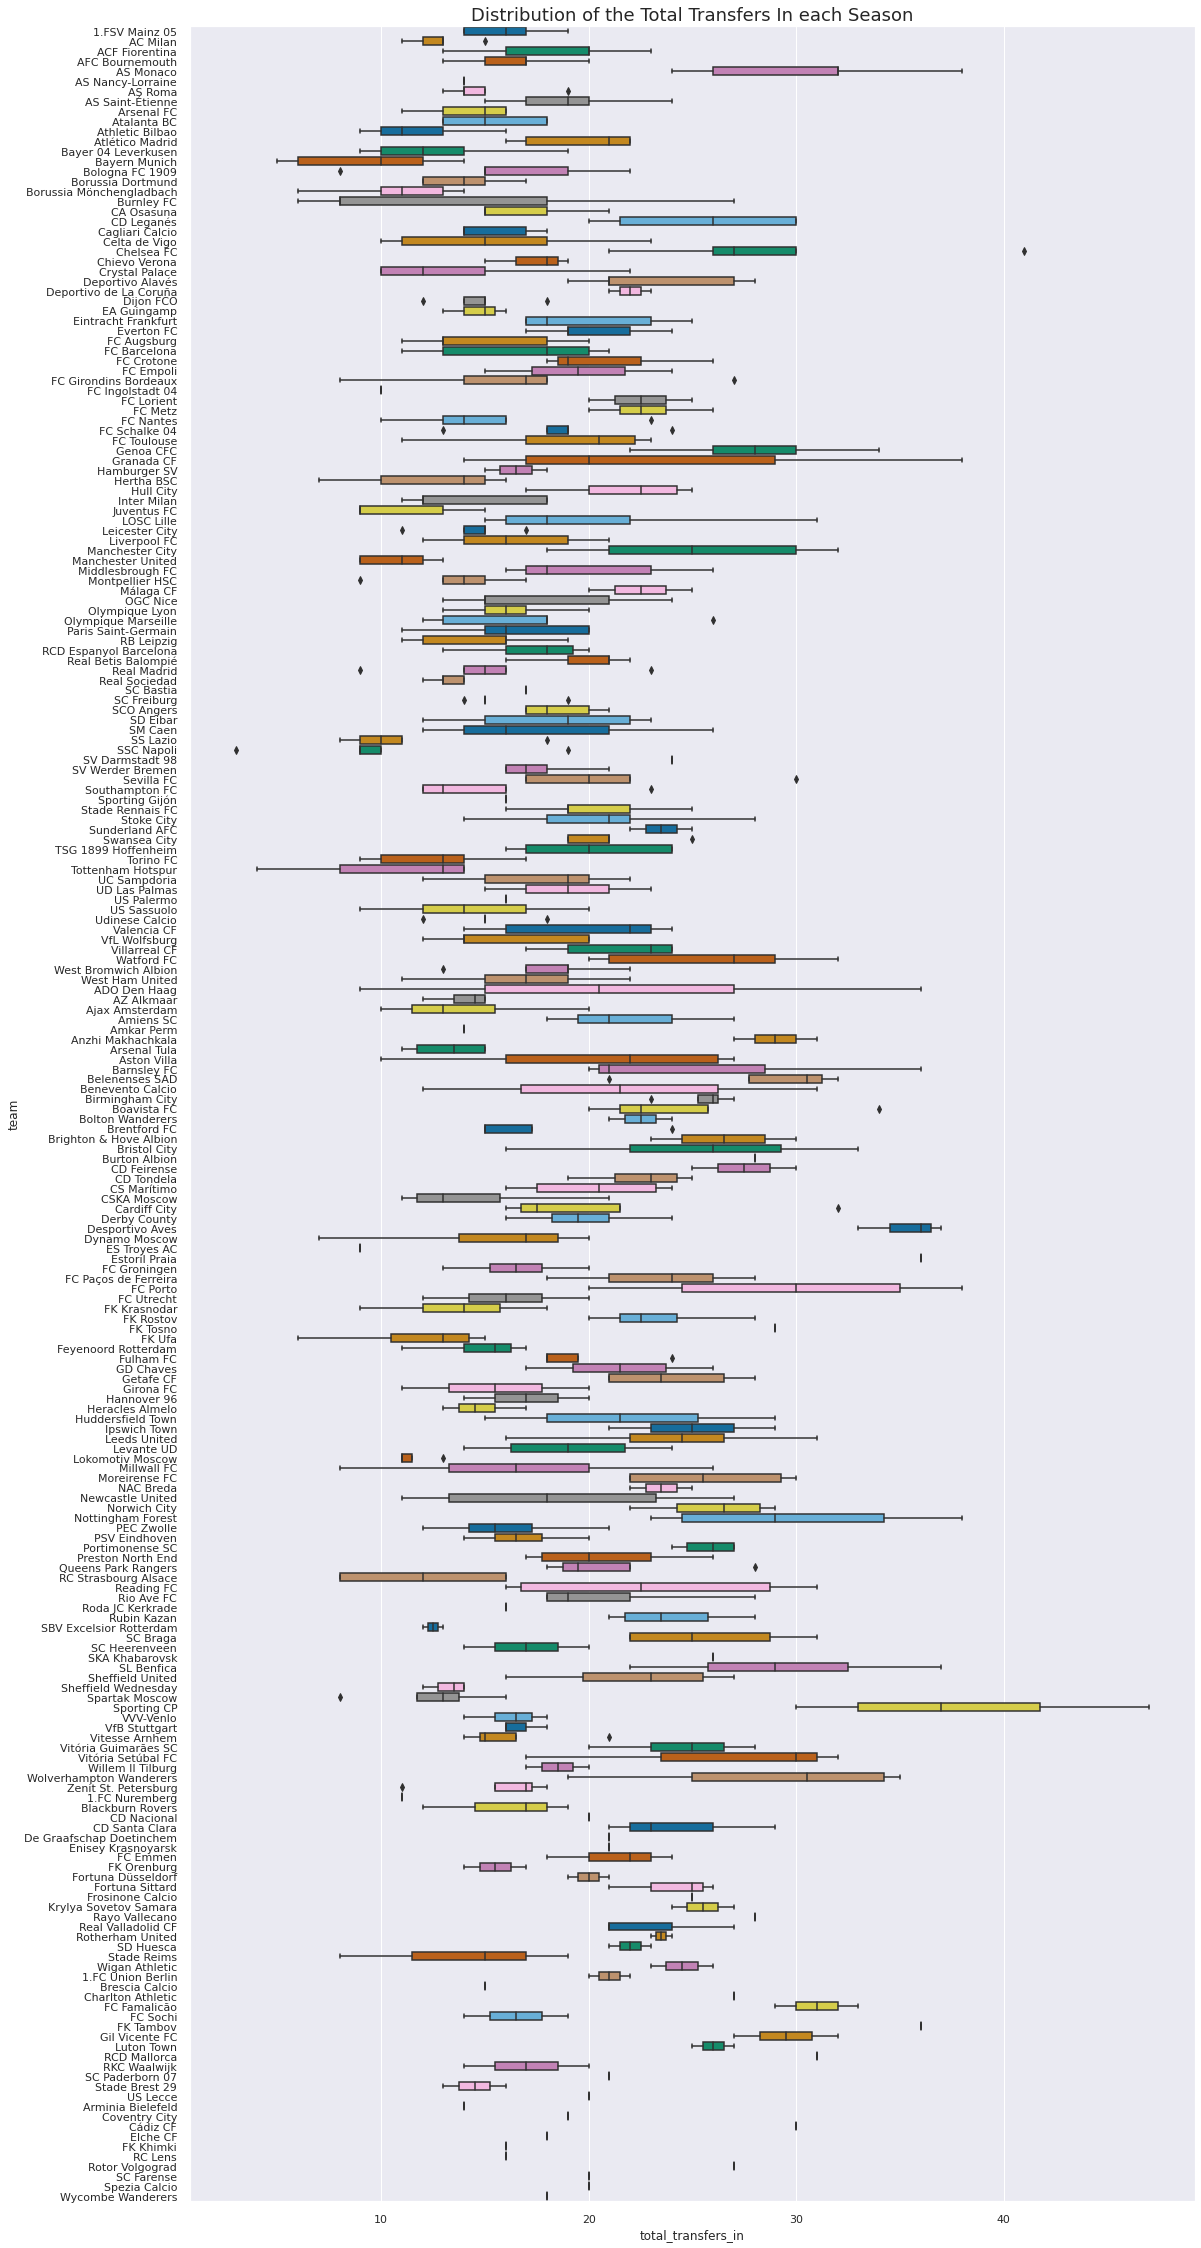

In [31]:
plt.figure(figsize=(18,40))
sns.boxplot(x='total_transfers_in', y='team', data=df, palette='colorblind')
plt.title('Distribution of the Total Transfers In each Season', fontsize=18);

#### I don't love a correlation matrix. I get why they are useful - they show how a dataset's features interact linearly in a positive or negative way.

But in my opinion, that's about all they show. From below, all I really know is that some of the columns interact really positively, e.g. `avg_season_spi`, the target variable, is positively impacted by five other features.

Fine. But next you'll see a plot of the feature importances in predicting `avg_season_spi`. This is a plot of the **Predictive Power Score**, which essentially uses evaluation metrics from a cross-validated Decision Tree to show predictive features. To learn more, see [this post on Towards Data Science](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598).

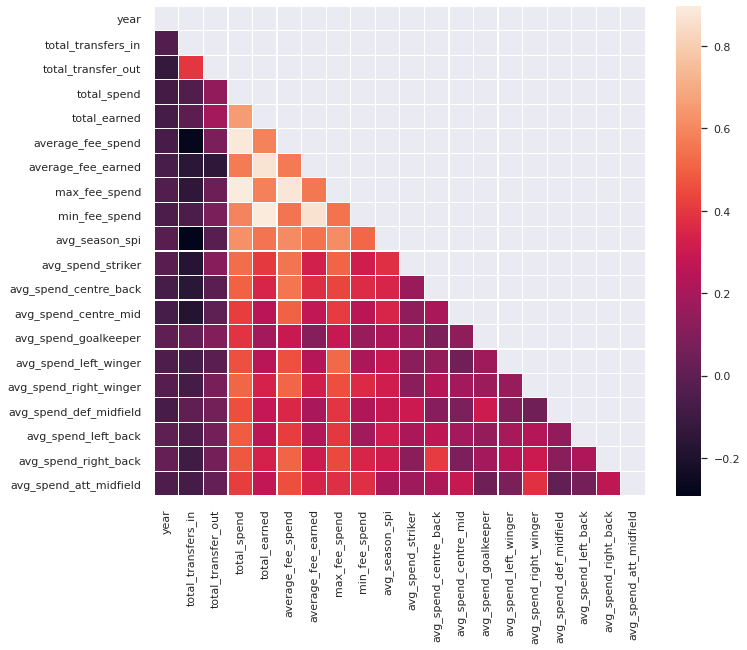

In [32]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, linewidths=.2);

Feature Importance in the prediction of avg_season_spi


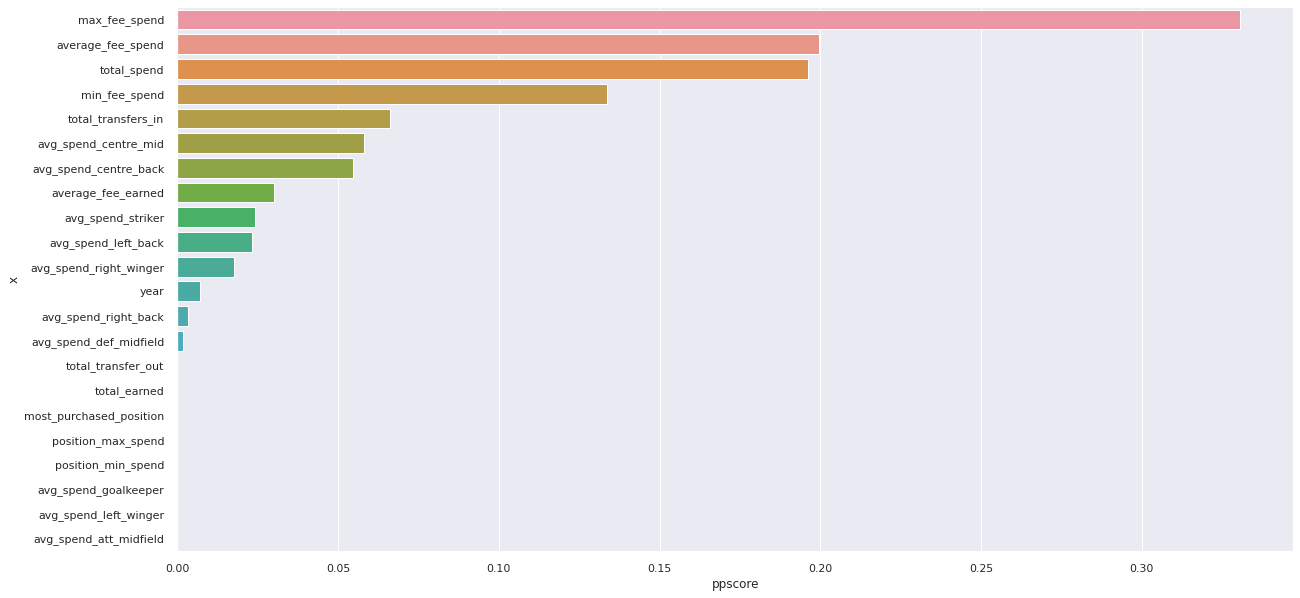

In [33]:
eda_numcat(df.drop(columns=['team', 'league']), 'avg_season_spi', method='pps')

In [34]:
eda_numcat(df, x=['year', 'league'], y=None, method='pivot')

Pivot View


average_fee_earned  average_fee_spend  \
year league                                                               
2016 English Premier League                     2.35               4.51   
     French Ligue 1                             0.96               0.92   
     German Bundesliga                          2.28               2.89   
     Italian Serie A                            0.81               2.88   
     Spanish La Liga                            1.29               1.50   
2017 Dutch Eredivisie                           0.94               0.37   
     English League Championship                0.48               0.45   
     English Premier League                     3.36               5.22   
     French Ligue 1                             1.53               2.07   
     German Bundesliga                          2.26               2.40   
     Italian Serie A                            1.03               3.78   
     Portuguese Liga                            0.52               0.14   
     Russian Premier Liga                       0.17               0.68   
     Spanish La Liga                            2.89               2.84   
2018 Dutch Eredivisie                           0.39               0.40   
     English League Championship                0.57               0.37   
     English Premier League                     1.33               4.13   
     French Ligue 1                             2.37               1.68   
     German Bundesliga                          2.23               1.84   
     Italian Serie A                            1.21               4.98   
     Portuguese Liga                            0.52               0.16   
     Russian Premier Liga                       0.62               0.50   
     Spanish La Liga                            2.34               2.41   
2019 Dutch Eredivisie                           1.31               0.38   
     English League Championship                0.74               0.43   
     English Premier League                     2.51               5.09   
     French Ligue 1                             2.46               2.00   
     German Bundesliga                          2.26               3.70   
     Italian Serie A                            1.38               4.85   
     Portuguese Liga                            0.97               0.34   
     Russian Premier Liga                       0.41               0.99   
     Spanish La Liga                            2.48               3.01   
2020 Dutch Eredivisie                           0.61               0.41   
     English League Championship                0.63               0.14   
     English Premier League                     1.25               4.07   
     French Ligue 1                             1.19               1.34   
     German Bundesliga                          1.53               1.44   
     Italian Serie A                            1.00               4.10   
     Portuguese Liga                            0.68               0.35   
     Russian Premier Liga                       0.27               0.71   
     Spanish La Liga                            1.51               0.87   

                                  avg_season_spi  avg_spend_att_midfield  \
year league                                                                
2016 English Premier League                66.05                    3.32   
     French Ligue 1                        59.51                    0.82   
     German Bundesliga                     70.18                    1.85   
     Italian Serie A                       62.19                    1.23   
     Spanish La Liga                       72.17                    1.04   
2017 Dutch Eredivisie                      41.33                    0.19   
     English League Championship           37.92                    0.34   
     English Premier League                64.68                    2.27   
     French Ligue 1                        59.52

### I think we've reached a good stopping point!

In future projects, I think I'll research the `ppscore` more closely. For now, I'm going to move on to a new stage of this project:

#### PRE-PROCESSING & MODELLING

In [35]:
df.to_csv('spi_transfers_features_created_no_frees.csv')